In [1]:
import os
import json

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import FFTDataModule
from model.AE_model import AECNN1DModel

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST = True

random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [21]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = AECNN1DModel(
    cnn_channel_param = [
        (6, 32, 8, 0, 3),
        (32, 64, 8, 0, 3)
    ],
    linear_channel_param = [
        256, 128
    ]).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name         | Type            | Params | In sizes     | Out sizes   
--------------------------------------------------------------------------------
0  | enc_cnn      | Sequential      | 18.0 K | [10, 6, 257] | [10, 64, 26]
1  | enc_cnn.0    | Conv1d          | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | enc_cnn.1    | ReLU            | 0      | [10, 32, 84] | [10, 32, 84]
3  | enc_cnn.2    | Dropout         | 0      | [10, 32, 84] | [10, 32, 84]
4  | enc_cnn.3    | Conv1d          | 16.4 K | [10, 32, 84] | [10, 64, 26]
5  | enc_cnn.4    | ReLU            | 0      | [10, 64, 26] | [10, 64, 26]
6  | enc_cnn.5    | Dropout         | 0      | [10, 64, 26] | [10, 64, 26]
7  | enc_linear   | Sequential      | 459 K  | [10, 1664]   | [10, 128]   
8  | enc_linear.0 | Linear          | 426 K  | [10, 1664]   | [10, 256]   
9  | enc_linear.1 | ReLU            | 0      | [10, 256]    | [10, 256]   
10 | enc_linear.2 | Linear          | 32.9 K | [10, 256]    | [10, 128]   
11 | enc_linear.3 |

In [4]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = "/nfs/ksdata/tran/HAR_AE/dataset/processed_concat_data"

log_save_dir = "lightning_logs"
log_save_name = "11_AE_5classes_10000data"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_mse",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_mse", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

net = AECNN1DModel(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    cnn_channel_param = [
        (6, 32, 8, 0, 3),
        (32, 64, 8, 0, 3)
    ],
    linear_channel_param = [
        256, 128
    ],
)

data_module = FFTDataModule(dataset_path=dataset_path, batch_size=batch_size)

trainer.fit(model=net, datamodule=data_module)
trainer.test(model=net, datamodule=data_module)

log_dir = trainer.logger.log_dir

with open(os.path.join(log_dir, "result.json"), "w") as f:
    json.dump(trainer.logged_metrics, f, indent=4)

In [12]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/11_AE_5classes_10000data/version_0/checkpoints/sample_epoch=4009-step=80200-val_loss=0.000000.ckpt"

data_module = FFTDataModule.load_from_checkpoint(checkpoint_path)
net = AECNN1DModel.load_from_checkpoint(checkpoint_path)

trainer = L.Trainer()

trainer.test(model=net, datamodule=data_module)
pred = trainer.predict(model=net, datamodule=data_module)
gt = list(map(lambda x: x[0], iter(data_module.predict_dataloader())))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 33.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse           0.0007263480219990015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 10/10 [00:00<00:00, 166.94it/s]


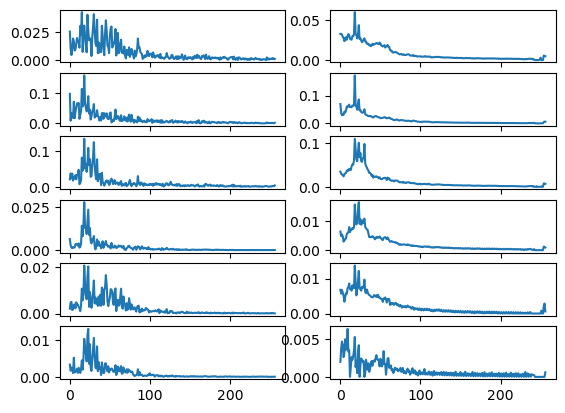

In [20]:
fig, axs = plt.subplots(6,2)

for i in range(6):
    axs[i,0].plot(gt[0][0][i])
    axs[i,1].plot(pred[0][0][i])
    